In [33]:
#pip install h5py

In [1]:
import h5py
import matplotlib.pyplot as plt  
from google.colab import drive,files
drive.mount('/content/drive')
import numpy as np
import pandas as pd

Mounted at /content/drive


In [35]:
f = h5py.File('/content/drive/My Drive/DataCamp/X_train_new.h5', 'r')

In [36]:
y_train_src=pd.read_csv('/content/drive/My Drive/DataCamp/y_train_AvCsavx.csv',index_col=False)

In [37]:
ytt=y_train_src['label']

In [38]:
ytt.value_counts()/946

0    0.77907
1    0.22093
Name: label, dtype: float64

In [39]:
list(f.keys())

['features']

In [40]:
dset = f['features']

In [41]:
dset.shape

(946, 40, 7, 500)

In [42]:
import torch
x = torch.tensor(dset[1][0][0], dtype=torch.float32)
y = x.view(250,2)
y.shape

torch.Size([250, 2])

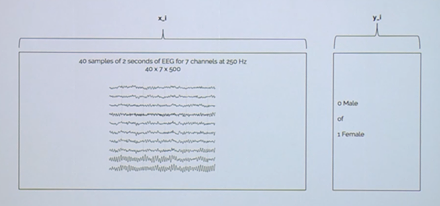

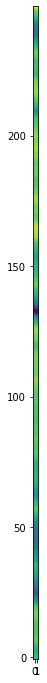

In [43]:
plt.figure(figsize=(6,12))
plt.imshow(y,origin='lower')


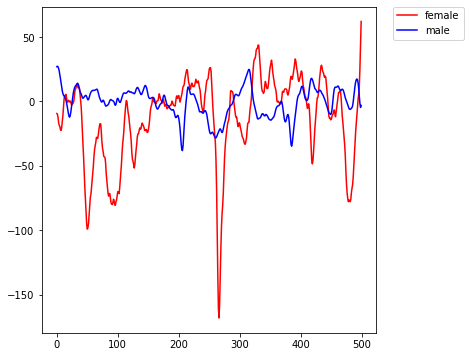

In [44]:
x1 = torch.tensor(dset[0][0][0], dtype=torch.float32)


import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.plot(x,color='r',label='female')
plt.plot(x1,color='b',label='male')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()


In [45]:
dset.dtype

dtype('<f4')

In [46]:
dset[0].shape

(40, 7, 500)

In [47]:
dset[0][0][0].shape

(500,)

In [48]:
import torch
#l=dset[1][0][0].tolist()
#for i in range(1,40):
#  l+=[dset[1][i][0].tolist()]
#l = torch.tensor(l, dtype=torch.float32)

x = torch.tensor(dset[1][0][0], dtype=torch.float32)


In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
d=torch.tensor(dset).to(device) #, dtype=torch.float32

In [50]:
dd = d.view(946,40*7,500)

In [51]:
d.shape,dd.shape

(torch.Size([946, 40, 7, 500]), torch.Size([946, 280, 500]))

In [52]:
x_train=dd
y_train_src=pd.read_csv('/content/drive/My Drive/DataCamp/y_train_AvCsavx.csv',index_col=False)

In [53]:
y_train=y_train_src['label']

In [54]:
y_train=y_train.tolist()

In [55]:
y=[]
for i in range(len(y_train)):
    for j in range(40):
        y+=[y_train[i]]

In [56]:
yt=torch.tensor(y).to(device) #, dtype=torch.float32

In [57]:
y_train=torch.tensor(y_train).to(device) #, dtype=torch.float32

In [58]:
yt.shape,y_train.shape,x_train.shape

(torch.Size([37840]), torch.Size([946]), torch.Size([946, 280, 500]))

In [59]:
x_train=x_train.view(946,40*7,250,2) #.float()


In [60]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, train_size=0.8)
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

torch.Size([756, 280, 250, 2])
torch.Size([190, 280, 250, 2])
torch.Size([756])
torch.Size([190])


In [61]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
train_ds = TensorDataset(x_train, y_train)
print("number of training samples", len(train_ds))
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True) # we usually shuffle the training data.
valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
print("number of training batches", len(train_dl))

number of training samples 756
number of training batches 24


In [62]:
# Loss Function.
import torch.nn.functional as F
loss_func = F.cross_entropy # Remember: the function F.cross_entropy combines the softmax function and the negative log-likelihood.

In [63]:
import torch.nn as nn
class deer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(280,100,(3,1))
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d((3,1), stride=1)
        self.conv2 = nn.Conv2d(100,100,(3,1))
        self.conv3 = nn.Conv2d(100,300,(3,1))
        #self.pool = nn.MaxPool2d(2, stride=1)
        self.fc1 = nn.Linear(300*238*2, 2)
        self.dp=nn.Dropout(p=0.2)

    def forward(self, xb):
        xb=self.conv1(xb)
        xb = self.relu(xb)
        xb=self.pool(xb)
        xb = self.dp(xb)
        #xb=self.pool(xb)
#        xb = xb.view(xb.size(0),-1).float()
        xb=self.conv2(xb)
        xb = self.relu(xb)
        xb=self.pool(xb)
        xb = self.dp(xb)
        xb=self.conv3(xb)
        xb = self.relu(xb)
        xb=self.pool(xb)
        xb = self.dp(xb)
        xb = xb.view(xb.size(0),-1)
        xb = self.fc1(xb)       
        return xb



In [64]:
x_train.shape,y_train.shape

(torch.Size([756, 280, 250, 2]), torch.Size([756]))

In [65]:
from torch import optim
def get_model(lr, device=device):
    model = deer()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model = model.to(device) # transferring the model to the GPU if available. 
    return model, optimizer

model, opt = get_model(lr=lr)

In [87]:
lr = 0.1
epochs = 10000
bs = 32

In [88]:
def fit(model, epochs, opt, loss_func, train_dl, valid_dl):
  fit.train_losss=[]
  fit.val_losss=[]
  for epoch in range(epochs):
      model.train() # useful for dropout. 
      train_loss = 0.
      for xb, yb in train_dl:
          # transfering data to device if GPU is available. 
        
          xb = xb.to(device)
          yb = yb.flatten().to(device)
          pred = model(xb)
          loss = loss_func(pred, yb)
          train_loss += loss
          loss.backward()
          opt.step()
          opt.zero_grad()
      # pass forward on the validation dataset. 
      model.eval() # useful for dropout. 
      with torch.no_grad():
          loss_valid = []
          for xb, yb in valid_dl:
              xb = xb.to(device)
              yb = yb.flatten().to(device)
              loss_valid.append(loss_func(model(xb), yb).cpu().item()) # .cpu() transfer back to the CPU. 
          valid_loss = sum(loss_valid) / len(loss_valid)
          #print(type(xb))
      print("Epoch: {}".format(epoch), "Train Loss: {:5.5f}".format(train_loss.cpu().item()/len(train_dl)), "Validation Loss: {:5.5f}".format(valid_loss))
      fit.train_losss+=[train_loss.cpu().item()/len(train_dl)]
      fit.val_losss+=[valid_loss]
fit(model, epochs, opt, loss_func, train_dl, valid_dl)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Epoch: 5000 Train Loss: 0.52300 Validation Loss: 0.54876
Epoch: 5001 Train Loss: 0.51985 Validation Loss: 0.54829
Epoch: 5002 Train Loss: 0.52197 Validation Loss: 0.54832
Epoch: 5003 Train Loss: 0.52821 Validation Loss: 0.55042
Epoch: 5004 Train Loss: 0.52292 Validation Loss: 0.54785
Epoch: 5005 Train Loss: 0.52265 Validation Loss: 0.54896
Epoch: 5006 Train Loss: 0.52187 Validation Loss: 0.54882
Epoch: 5007 Train Loss: 0.52314 Validation Loss: 0.54904
Epoch: 5008 Train Loss: 0.52492 Validation Loss: 0.54919
Epoch: 5009 Train Loss: 0.52375 Validation Loss: 0.54848
Epoch: 5010 Train Loss: 0.52389 Validation Loss: 0.54807
Epoch: 5011 Train Loss: 0.52197 Validation Loss: 0.54886
Epoch: 5012 Train Loss: 0.52281 Validation Loss: 0.54847
Epoch: 5013 Train Loss: 0.52082 Validation Loss: 0.54864
Epoch: 5014 Train Loss: 0.52421 Validation Loss: 0.54907
Epoch: 5015 Train Loss: 0.52176 Validation Loss: 0.54830
Epoch: 501

In [89]:
torch.save(model.state_dict(), '/content/drive/My Drive/DataCamp/model10000.pth')


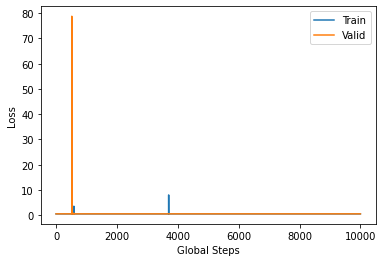

In [90]:
global_steps_list=[i for i in range(0,epochs)]
train_loss_list, valid_loss_list=fit.train_losss, fit.val_losss
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [91]:
# Accuracy Score. 
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1) # classe prédite: tensor de taille bs. 
    return (preds == yb).float().mean()

In [92]:
def validation_accuracy(model, dl):
  acc = [accuracy(model(xb.to(device)), yb.to(device)) for xb, yb in dl]
  acc = sum(acc) / len(acc)
  print('Accuracy on validation dataset', acc)
validation_accuracy(model, valid_dl)

Accuracy on validation dataset tensor(0.7631, device='cuda:0')


In [2]:
x_test_h5=h5py.File('/content/drive/My Drive/DataCamp/X_test_new.h5', 'r')

In [3]:
x_test=x_test_h5['features']

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
x_test=torch.tensor(x_test).to(device)

In [ ]:
model = deer()
model.load_state_dict(torch.load( '/content/drive/My Drive/DataCamp/model10000.pth'))
model.to(device)

In [76]:
x_test = x_test.view(946,40*7,250,2)

In [77]:
x_test.shape

torch.Size([946, 280, 250, 2])

In [78]:
pred=model(x_test)

In [79]:

#test_ds = TensorDataset(x_test)
test_dl = DataLoader(x_test, batch_size=bs, shuffle=True) # we usually shuffle the training data.

print("number of testing samples", len(test_dl))


number of testing samples 30


In [80]:
predictions = []
for batch in test_dl:
    batch=batch.to(device)      
    p= model(batch)
    predictions.append(torch.argmax(p, dim=1).tolist())

In [131]:
len(predictions[-2]),type(p),len(p),p.shape

(32, torch.Tensor, 18, torch.Size([18, 2]))

In [81]:
prediction=torch.tensor(predictions[:-1]).to(device)

In [82]:
prediction=prediction.view(32*29)

In [83]:
prediction_f=prediction.tolist()

In [84]:
prediction_f+=predictions[-1]

In [139]:
len(prediction_f)

946

In [156]:
prediction_f.index(1)

538

In [85]:
d= {'label': prediction_f}
df_t=pd.DataFrame(d)
df_t = df_t.reset_index()


In [159]:
df_t.head()

,index,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [86]:
df_t.to_csv('/content/drive/My Drive/DataCamp/df_t1.csv', index = False)


### **TensorFlow**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.python.keras.optimizers import Adam


In [ ]:
yt_tf=tf.convert_to_tensor(yt.cpu())
dd_tf=tf.convert_to_tensor(dd.cpu())

In [ ]:
dd_tf=tf.reshape(dd_tf,(37840,250,2,7))
dd_tf.shape

TensorShape([37840, 250, 2, 7])

In [ ]:
input_shape=dd_tf.shape
num_classes=2

model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(37840, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
#Compile
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
print(model.summary())
#Train and Test The Model
model.fit(dd_tf, yt_tf, batch_size=4, epochs=10, verbose=1, validation_data=(dd_tf, yt_tf))

ResourceExhaustedError: ignored

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [ ]:
x_train=h5py.File('/content/drive/My Drive/DataCamp/X_train_new.h5', 'r')
y_train_src=pd.read_csv('/content/drive/My Drive/DataCamp/y_train_AvCsavx.csv',index_col=False)

In [ ]:
y_train=y_train_src['label']

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
#Compile
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.adam(), metrics=['accuracy'])
print(model.summary())
#Train and Test The Model
model.fit(x_train, y_train, batch_size=4, epochs=10, verbose=1, validation_data=(x_test, y_test))